Calculate the distance bandwidth of virtual and real space

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import numpy as np
import csv

In [6]:
year = "2020"

In [7]:
# 获取距离字典
distance_dict = {}
dis_matrix = []
with open('data\distance_matrix.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        dis_matrix.append([float(i) for i in row])

for row in range(1, len(dis_matrix)+1):
    for col in range(1, len(dis_matrix[0])+1):
        if row in distance_dict.keys():
            distance_dict[row][col] = dis_matrix[row-1][col-1]
        else:
            distance_dict[row] = {col: dis_matrix[row-1][col-1]}

# 获取人流量和搜索流量字典
root_filepath = 'data/'
travelindex_distance_list = []
filepath_list = [root_filepath + f"travel_{time}_normalized_xy.csv" for time in [year]]
for filepath in filepath_list:
    df = pd.read_csv(filepath)
    for _, row in df.iterrows():
        travelindex_distance_list.append((distance_dict[row['NodeID1']][row['NodeID2']], row['Weight']))

searchindex_distance_list = []
filepath_list = [root_filepath + f"search_{time}_normalized_xy.csv" for time in [year]]
for filepath in filepath_list:
    df = pd.read_csv(filepath)
    for _, row in df.iterrows():
        searchindex_distance_list.append((distance_dict[row['NodeID1']][row['NodeID2']], row['Weight']))

# 提取数据
travelindex_distance_list = sorted(travelindex_distance_list, key=lambda x: x[0])
searchindex_distance_list = sorted(searchindex_distance_list, key=lambda x: x[0])

travel = [[item[0] for item in travelindex_distance_list if item[0] > 0], [item[1] for item in travelindex_distance_list if item[0] > 0]]
search = [[item[0] for item in searchindex_distance_list if item[0] > 0], [item[1] for item in searchindex_distance_list if item[0] > 0]]

data_array = np.array(travel[0])
normalized_data = (data_array - np.min(data_array)) / (np.max(data_array) - np.min(data_array))
travel[0] = normalized_data.tolist()

data_array = np.array(search[0])
normalized_data = (data_array - np.min(data_array)) / (np.max(data_array) - np.min(data_array))
search[0] = normalized_data.tolist()

# 高斯函数
def gaussian_decay(x, A, sigma):
    return A * np.exp(-((x)**2) / (2 * sigma**2))

print("travel:")
x_data = np.array(travel[0])
y_data = np.array(travel[1])
popt, pcov = curve_fit(gaussian_decay, x_data, y_data)

apop_p, sigma_opt_p = popt
print(f"最佳拟合的 A 值: {apop_p}")
print(f"最佳拟合的 sigma 值: {sigma_opt_p}")

# 计算拟合的 y 值
y_fit = gaussian_decay(x_data, apop_p, sigma_opt_p)

r2 = r2_score(y_data, y_fit)
print(f"拟合精度 R²: {r2} \n")

travel.append(y_fit)

print("search:")
x_data = np.array(search[0])
y_data = np.array(search[1])
popt, pcov = curve_fit(gaussian_decay, x_data, y_data)

apop_v, sigma_opt_v = popt
print(f"最佳拟合的 A 值: {apop_p}")
print(f"最佳拟合的 sigma 值: {sigma_opt_v}")
# 计算拟合的 y 值
y_fit = gaussian_decay(x_data, apop_v, sigma_opt_v)

r2 = r2_score(y_data, y_fit)
print(f"拟合精度 R²: {r2}")

search.append(y_fit)

print(f"p:v: {(sigma_opt_v**2)/(sigma_opt_p**2)}")

travel:
最佳拟合的 A 值: 0.06367955505594047
最佳拟合的 sigma 值: 0.0205716826685458
拟合精度 R²: 0.2105141173916023 

search:
最佳拟合的 A 值: 0.06367955505594047
最佳拟合的 sigma 值: 0.03884410030138893
拟合精度 R²: 0.13506519207282608
p:v: 3.5654183956038406


拟合函数

Text(0.5, 1.0, 'Search Index')

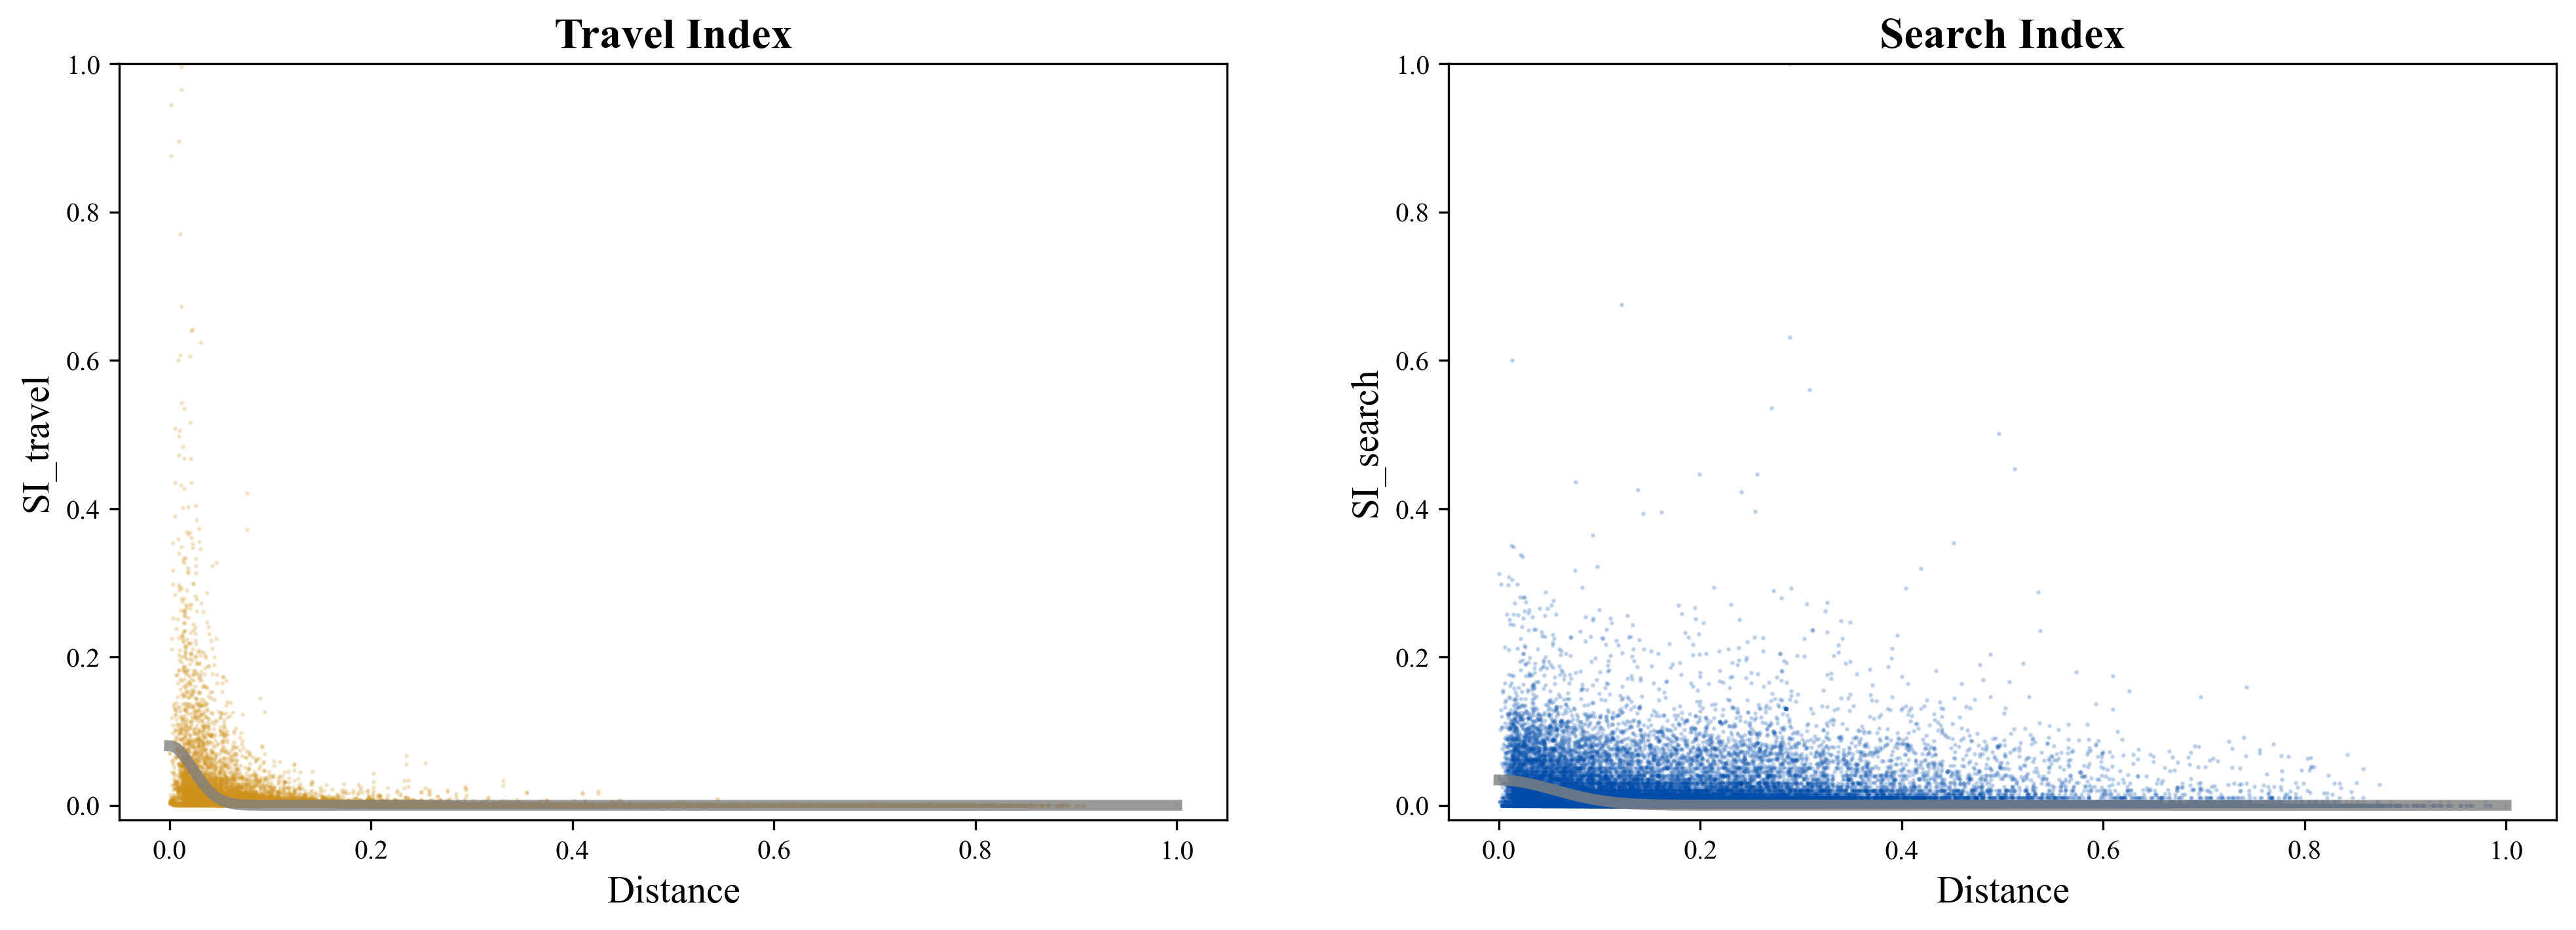

In [225]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=300)
plt.rcParams['font.family'] = 'Times New Roman'

axes[0].scatter(travel[0], travel[1], s = 0.5, c="#d0911c", alpha=0.2)
axes[0].plot(travel[0], travel[2], color="gray", linewidth=4, alpha=0.8)

axes[1].scatter(search[0], search[1], s = 0.5, c="#024CAA", alpha=0.2)
axes[1].plot(search[0], search[2], color="gray", linewidth=4, alpha=0.8)

for n in range(2):
    axes[n].set_ylim(-0.02, 1)
    axes[n].set_xlabel('Distance', fontdict={'family': 'Times New Roman', 'size': 14})

axes[0].set_ylabel('SI_travel', fontdict={'family': 'Times New Roman', 'size': 14})
axes[1].set_ylabel('SI_search', fontdict={'family': 'Times New Roman', 'size': 14})

axes[0].set_title('Travel Index', fontdict={'family': 'Times New Roman', 'size': 16, 'weight': 'bold'})
axes[1].set_title('Search Index', fontdict={'family': 'Times New Roman', 'size': 16, 'weight': 'bold'})

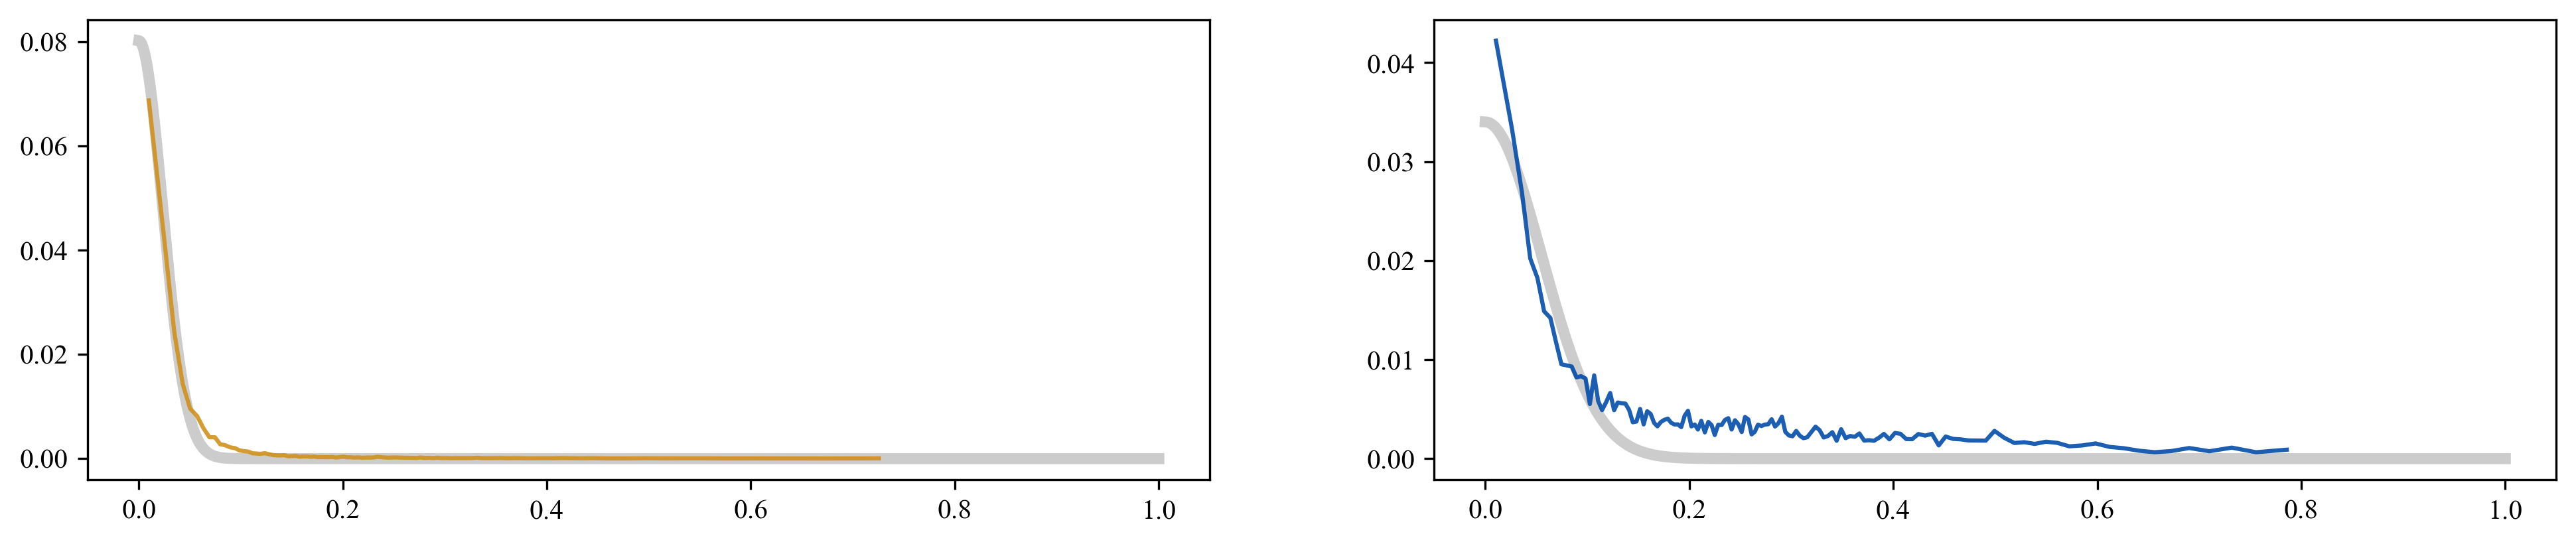

In [234]:
def get_avg(x_data, y_data):
    n = 1000
    num = len(x_data)//n

    # 计算每个区间的平均 y 值
    avg_y = []
    avg_x = []

    for i in range(num):
        avg_y.append(np.mean(y_data[i*n : (i+1)*n]))
        avg_x.append((x_data[i*n] + x_data[(i+1)*n]) / 2)

    # 将结果转换为 numpy 数组
    avg_x = np.array(avg_x)
    avg_y = np.array(avg_y)

    return avg_x, avg_y

fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=300)
plt.rcParams['font.family'] = 'Times New Roman'

avg_x_1, avg_y_1 = get_avg(travel[0], travel[1])
avg_x_2, avg_y_2 = get_avg(search[0], search[1])

axes[0].plot(travel[0], travel[2], color="gray", linewidth=4, alpha=0.4)
axes[1].plot(search[0], search[2], color="gray", linewidth=4, alpha=0.4)

axes[0].plot(avg_x_1, avg_y_1, color="#d0911c", linewidth=1.5, alpha=0.9)
axes[1].plot(avg_x_2, avg_y_2, color="#024CAA", linewidth=1.5, alpha=0.9)

# axes[0].set_xlim(0, 40)
# axes[1].set_xlim(0, 40)
